In [52]:
import numpy as np
import pandas as pd
import json
import netCDF4 as nc
import pyarrow as pa
import pyarrow.parquet as pq
import fastparquet as fpq
import fastavro as avro
import pyarrow.feather as feather
import uuid
import os
from time import time_ns
from time import sleep
from enum import Enum
import matplotlib.pyplot as plt

## I/O speed tests

### Write speed (average of 100)
- As a function of # of rows (5 columns worth, 2e3 - 1e6 points)

### Read (average of 100):
- Metadata read (how long to access one scan’s metadate)
- Column read (how long to access two columns [but check by column])

### Data efficiency
- Storage size as function of rows for 5 columns
- Storing meta experiments in one file vs many (as a function of n experiments)


### Possible solutions
- <span style='color:khaki'> CSV </span>
- <span style='color:black'> JSON </span>
- <span style='color:green'> NetCDF </span> and <span style='color:lime'> NetCDF with compression </span>
- <span style='color:magenta'> Parquet </span>,<span style='color:pink'> Parquet compiled</span>  and <span style='color:hotpink'> Fast Parquet compiled</span>
- <span style='color:red'> Feather </span>
- <span style='color:blue'> Avro </span>

In [53]:
# Common functions and values
def make_test_meta():
    test_meta = {'uuid': str(uuid.uuid1()),
                'param1':12,
                'param2':'a_string',
                'param3': np.random.rand()*1e9,
                'param4':['alist','of','strings']}
    return test_meta

def make_test_data(length_of_data):
    test_data = {'time' :(np.array(range(length_of_data))*1e-9).tolist(), # to_list is necessary because json.dumps only takes native python types not numpy types
                 'vals' : np.random.randn(length_of_data).tolist(),
                 'volts': np.random.randn(length_of_data).tolist(), #dummy col names and values to fill columns
                 'dp'   : np.random.randn(length_of_data).tolist(),
                 'dr'   : np.random.randn(length_of_data).tolist()}
    return test_data

def read_data_metrics_file(source):
    with open(source, 'r') as f:
        lines = f.readlines()
    result = {}
    for line in lines:
        subjson = json.loads(line.rstrip(r'\n'))
        for key, item in subjson.items():
            result[key] = item

    return result

def write_data_metrics_to_file(cur_data_metrics, format_type, data_metrics_dict = None,fp = None):
    if fp is None:
        fp = 'data_metrics.json'

    if data_metrics_dict is None:
        data_metrics_dict = read_data_metrics_file(fp)
    
    data_metrics_dict[format_type] = [] # clear any previous test values
    data_metrics_dict[format_type].extend(cur_data_metrics) # Add to the dictionary
    
    then = time_ns()
    with open(fp,'w+') as f:
        to_write = json.dumps(data_metrics_dict)
        f.write(to_write+'\r')
    now = time_ns()
    return (now-then) * 1e-9


def get_col_names():
    return ['time', 'vals', 'volts', 'dp', 'dr']
def round_4(val):
    return round(val, 4)

In [102]:
def setup_test():
    start_len, end_len, total_data_points = 2000, 1000000, 20
    test_lens = [2000, 5000, 10000]
    ns_to_write = [int(x) for x in np.geomspace(1, 100, 3)]
    data_lengths_across_n = []
    for n in ns_to_write:
        data_lengths = [int(x) for x in np.geomspace(start_len, end_len/n, total_data_points)]
        data_lengths_across_n.append(data_lengths)
    return data_lengths_across_n, ns_to_write

In [119]:
def metric_tests(data_lengths, n_to_write, fp, write_function, read_function, wargs = None, rargs=None):
    w_avg = []
    fs_avg = [] 
    meta_r_avg = []
    col_r_avg = []

    for length_of_data in data_lengths:
        then = time_ns()
        total_w_time = 0
        total_size = 0
        total_metatime = 0
        total_coltime = 0
        tests_per_data_len = 10 if length_of_data >= 500000 else 100
        for i in range(tests_per_data_len):
            # Writing
            if wargs is None:
                wtime, size = write_function(length_of_data, n_to_write, fp)
            else:
                wtime, size = write_function(length_of_data, n_to_write, fp, wargs)
                
            total_w_time += wtime

            # Size
            total_size += size

            # Reading
            if rargs is None:
                metatime, coltime = read_function(fp)
            else:
                metatime, coltime = read_function(fp, rargs)
            total_metatime += metatime
            total_coltime += coltime

        w_avg.append(round_4(total_w_time / tests_per_data_len))
        fs_avg.append(round_4(total_size / tests_per_data_len))
        meta_r_avg.append(round_4(total_metatime / tests_per_data_len))
        col_r_avg.append(round_4(total_coltime / tests_per_data_len))

        now = time_ns()
        exptime = round_4((now-then)*1e-9)
        print(f'For {length_of_data} rows, write: {w_avg[-1]} s, readmeta: {meta_r_avg[-1]}s',
              f' readcol: {col_r_avg[-1]} s, size: {fs_avg[-1]} KB, n: {n_to_write}, totaltime: {exptime} s')
    return w_avg, fs_avg, meta_r_avg, col_r_avg

In [56]:
# Complete tests across all n
def metric_tests_across_n(data_lengths_across_n, ns_to_write, fp, write_function, read_function, wargs = None, rargs=None):
    
    w_avg_across_n = [] # A list write times for each n, 3 writelists, each of len(20)
    fs_avg_across_n = []
    meta_r_avg_across_n = []
    col_r_avg_across_n = []


    start = time_ns()
    for index, n in enumerate(ns_to_write):
        w, fs, meta, col = metric_tests(data_lengths_across_n[index], n, fp,  write_function, read_function, wargs, rargs )
        w_avg_across_n.append(w)
        fs_avg_across_n.append(fs)
        meta_r_avg_across_n.append(meta)
        col_r_avg_across_n.append(col)
 
    finish = (time_ns() - start)*1e-9
    print(f"Total time for test {finish/60} mins")
    all_metrics = [w_avg_across_n,fs_avg_across_n,  meta_r_avg_across_n, col_r_avg_across_n]
    return all_metrics

In [121]:
# Local storage of results
# data_metrics_results = {'CSV':[], 'JSON': [], 'NetCDF': [], 'NetCDFwComp':[], 'Parquet':[],
#                         'ParquetwCompile':[] ,'FastParquet':[], 'Feather':[], 'Avro':[]}
# res = read_data_metrics_file('data_metrics.json')
# for key, val in res.items():
#     if(val):
#         data_metrics_results[key] = val

# print(data_metrics_results)

# write_data_metrics_to_file([], 'CSV', data_metrics_results )
data_metrics_results = read_data_metrics_file('data_metrics.json')
print(data_metrics_results.keys())
# print(data_metrics_results)

dict_keys(['CSV', 'JSON', 'NetCDF', 'NetCDFwComp', 'Parquet', 'ParquetwCompile', 'FastParquet', 'Feather', 'Avro'])


## JSON Tests

In [19]:
# JSON data write/read methods 
def make_json_datastore(testdata, meta=None):
    if meta is None:
        test_meta = make_test_meta()
    metadata_as_string = json.dumps(test_meta)
    kepler_json_format = {metadata_as_string: testdata}
    return kepler_json_format

def JSON_write_n_to_file(length_of_data, n_to_write, fp = None):
    if fp is None:
        fp = 'JSONTestFile.json'
    if os.path.exists(fp):
        os.unlink(fp)

    then = time_ns()
    with open(fp,'w+') as f:
        for i in range(n_to_write):
            jsonified_data = make_json_datastore(make_test_data(length_of_data)) 
            to_write = json.dumps(jsonified_data)
            f.write(to_write+'\r')
    now = time_ns()
    file_size = os.path.getsize(fp)/1000 #to get in kb
    return (now-then) * 1e-9, file_size

def JSON_load(source):
    then = time_ns()
    with open(source, 'r') as f:
        lines = f.readlines()
    metajson = {}
    # each line is one experiment and all of its data
    for line in lines:
        subjson = json.loads(line.rstrip(r'\n'))
        # The key is the metadata string and the item is a dictionary of the data
        for key, item in subjson.items():
            metajson[key] = item
    metadata_read = (time_ns() - then)*1e-9
    columns_read = metadata_read # For JSON these are the same

    return metadata_read, columns_read

In [8]:
# small test to check functionality
fp = 'testfile.json'
writetime, filesize = JSON_write_n_to_file(5000, 100, fp)
metadata_read, columns_read = JSON_load('testfile.json')

print(f'time to write: {writetime} s, time to metaread {metadata_read} s and colread is {columns_read} s, size is {filesize} KB')

time to write: 5.5095179000000005 s, time to metaread 2.7616084 s and colread is 2.7616084 s, size is 49232.263 KB


In [21]:
# RUN the entire JSON test
def JSON_data_metrics():
    fp = 'JSONTestFile.json'
    data_lengths_across_n, ns_to_write = setup_test()
    write_function = JSON_write_n_to_file
    read_function = JSON_load

    print(f"Metrics for JSON format")
    all_metrics = metric_tests_across_n(data_lengths_across_n, ns_to_write,fp,write_function, read_function )
    return all_metrics
    

# JSON_all_metrics = JSON_data_metrics()
# print(JSON_all_metrics)
# write_data_metrics_to_file(JSON_all_metrics, 'JSON') #Saving the data


## NetCDF Tests

In [8]:
# NetCDF methods
def NC_make_meta_groupname(meta=None):
    if meta is None:
        test_meta = make_test_meta()
    metadata_as_string = "x"+ json.dumps(test_meta) # first character needs to a be letter 
    return metadata_as_string

def NC_write_n_to_file(length_of_data, n_to_write, fp = None, wargs = (False,)):
    
    if fp is None:
        fp = 'NetCDFTestFile.nc'
        
    if os.path.exists(fp):
        os.unlink(fp)
    
    then = time_ns()
    comp, = wargs

    with nc.Dataset(fp, "w", format="NETCDF4") as rootgrp:   
        # Add global dimensions to be used in each group, aka global constants
        for col_name in get_col_names():
            rootgrp.createDimension(col_name, length_of_data)

        # Create n groups
        for i in range(n_to_write):
            # create group to hold values of each nth experiment
            testgrp = rootgrp.createGroup(NC_make_meta_groupname())

            test_data = make_test_data(length_of_data)
            # create variables
            for col_name in get_col_names():
                # name = col_name, datatype = f8(np.float64), size = rootgrp.dimensions['x'], also just (col_name)
                if comp:
                    var = testgrp.createVariable(col_name, "f8", (rootgrp.dimensions[col_name],), compression='zlib')
                else:
                    var = testgrp.createVariable(col_name, "f8", (rootgrp.dimensions[col_name],)) 
                var[:] = test_data[col_name]  # fill in the data
     
    now = time_ns()
    file_size = os.path.getsize(fp)/1000
    return (now-then) * 1e-9, file_size


def NC_load(source):
    then = time_ns()
    
    with nc.Dataset(source) as rootgrp:
        # get meta data, stored as a dictionary of group names
        metadata = rootgrp.groups.keys()
        metadata_read = (time_ns() - then)*1e-9

        # get coldata
        for group in rootgrp.groups.values():
            time =  group.variables['time'][:]
            volts = group.variables['volts'][:]
            vals = group.variables['vals'][:]

    columns_read = (time_ns() - then)*1e-9 

    return metadata_read, columns_read


In [9]:
fp = 'NetCDFTestFile.nc'
writetime, filesize = NC_write_n_to_file(20, 1, fp, wargs = (True,))
metadata_read, columns_read = NC_load(fp)
print(f'time to write: {round_4(writetime)} s, time to metaread {round_4(metadata_read)} s and colread is {round_4(columns_read)} s, size is {round_4(filesize)} KB')

time to write: 0.0974 s, time to metaread 0.008 s and colread is 0.008 s, size is 20.501 KB


In [11]:
# RUN the entire NC test
def NC_data_metrics():
    fp = 'NetCDFTestFileComp.nc'
    data_lengths_across_n, ns_to_write = setup_test()
    write_function = NC_write_n_to_file
    read_function = NC_load
    comp = True
    wargs = (comp,)
    print(f"Metrics for NetCDF format w comp:{comp}")
    all_metrics = metric_tests_across_n(data_lengths_across_n, ns_to_write,fp,write_function, read_function, wargs )
    return all_metrics


# NC_comp_all_metrics = NC_data_metrics()
# print(NC_comp_all_metrics)
# write_data_metrics_to_file(NC_comp_all_metrics, 'NetCDFwComp')

# NC_all_metrics = = NC_data_metrics()
# print(NC_all_metrics)
# write_data_metrics_to_file(NC_all_metrics, 'NetCDF') 

## Parquet tests

In [10]:
# Parquet methods
def PQ_make_meta_groups(n_to_write):
    metadata_rows = {}
    for i in range(n_to_write):
        test_meta = json.dumps(make_test_meta())
        metadata_rows[test_meta] = i
    return json.dumps(metadata_rows)


def PQ_create_schema_w_meta(n_to_write):
    df = pd.DataFrame(make_test_data(1)) # Small dataframe to get pandas schema
    table = pa.Table.from_pandas(df, preserve_index=False)
    row_group_mappings = PQ_make_meta_groups(n_to_write)
    custom_metadata = {'row_group_meta': row_group_mappings}
    existing_metadata = table.schema.metadata
    merged_metadata = { **custom_metadata, **existing_metadata }
    table = table.replace_schema_metadata(merged_metadata)
    return table.schema

def PQ_write_n_to_file(length_of_data, n_to_write, fp = None,  wargs = (False,)):
    
    if fp is None:
        fp = 'PQTestFile.parquet'
        
    if os.path.exists(fp):
        os.unlink(fp)
    
    then = time_ns()
    compile_data, = wargs
    
    my_schema = PQ_create_schema_w_meta(n_to_write)
    if compile_data:
        all_data = []
        for i in range(n_to_write):
            df = pd.DataFrame(make_test_data(length_of_data))       
            all_data.append(df) #compile

        df = pd.concat(all_data, ignore_index=True)
        table = pa.Table.from_pandas(df, preserve_index=False)
        with pq.ParquetWriter(fp, my_schema) as writer:
            writer.write_table(table, row_group_size = length_of_data)
    else:
        with pq.ParquetWriter(fp, my_schema) as writer:
            for i in range(n_to_write):
                df = pd.DataFrame(make_test_data(length_of_data))
                table = pa.Table.from_pandas(df, preserve_index=False)
                writer.write_table(table, row_group_size = length_of_data)
    
    now = time_ns()
    file_size = os.path.getsize(fp)/1000 #to get in kb
    return (now-then) * 1e-9, file_size


def PQ_load(source):
    then = time_ns()

    # Accessing meta
    metadata_pq = pq.read_metadata(source)
    meta = metadata_pq.metadata[b'row_group_meta']
    row_group_mappings = json.loads(meta)
    metadata_read = (time_ns() - then)*1e-9

    # Accessing columns
    with pq.ParquetFile(source) as parquet_file:
        for row_num in row_group_mappings.values():
            table = parquet_file.read_row_group(row_num, columns=['time', 'vals','volts']).to_pandas()

    columns_read = (time_ns() - then)*1e-9 

    return metadata_read, columns_read

In [11]:
# small test to check functionality
fp = 'PQTestFile.parquet'
compile_data = True
writetime, filesize = PQ_write_n_to_file(10, 1, fp, (compile_data,))
metadata_read, columns_read = PQ_load(fp)
print(f'time to write: {round_4(writetime)} s, time to metaread {round_4(metadata_read)} s and colread is {round_4(columns_read)} s, size is {round_4(filesize)} KB')

time to write: 0.0089 s, time to metaread 0.0157 s and colread is 0.0178 s, size is 4.569 KB


In [112]:
# RUN the entire PQ test
def PQ_data_metrics():
    fp = 'PQTestFile.parquet'
    data_lengths_across_n, ns_to_write = setup_test()

    write_function = PQ_write_n_to_file
    read_function = PQ_load
    compile_data = True
    wargs = (compile_data,)
    print(f"Metrics for Parquet format w compile:{compile_data}")
    all_metrics = metric_tests_across_n(data_lengths_across_n, ns_to_write,fp,write_function, read_function, wargs )

    return all_metrics


# PQ_all_metrics = PQ_data_metrics()
# print(PQ_all_metrics)
# PQ_compile_all_metrics = PQ_data_metrics()
# print(PQ_compile_all_metrics)
# write_data_metrics_to_file(PQ_compile_all_metrics, 'ParquetwCompile') #Saving the data

## Fastparquet

In [14]:
def FPQ_make_custom_meta(n_to_write):
    metadata_rows = {}
    for i in range(n_to_write):
        test_meta = json.dumps(make_test_meta())
        metadata_rows[test_meta] = i
    row_group_mappings = json.dumps(metadata_rows)
    custom_metadata = {'row_group_meta': row_group_mappings}
    return custom_metadata

def FPQ_write_n_to_file(length_of_data, n_to_write, fp = None, wargs = (False,)):
    
    if fp is None:
        fp = 'FPQTestFile.parq'
        
    if os.path.exists(fp):
        os.unlink(fp)
    
    then = time_ns()
    compile_data, = wargs

    custom_metadata = FPQ_make_custom_meta(n_to_write)
    
    if compile_data:
        all_data = []
        for i in range(n_to_write):
            df = pd.DataFrame(make_test_data(length_of_data)) 
            all_data.append(df)
        df = pd.concat(all_data, ignore_index=True)
        fpq.write(fp, df, row_group_offsets = length_of_data, custom_metadata = custom_metadata) 
    else:
        for i in range(n_to_write):
            df = pd.DataFrame(make_test_data(length_of_data)) 
            if i == 0:
                fpq.write(fp, df, row_group_offsets = length_of_data, custom_metadata = custom_metadata)
            else:
                file = fpq.ParquetFile(fp)
                file.write_row_groups(df, row_group_offsets = length_of_data)
#             sleep(0.1) #Test sleep for 100ms to give time to close file      
        
    now = time_ns()
    file_size = os.path.getsize(fp)/1000
    return (now-then) * 1e-9, file_size


def FPQ_load(source):
    then = time_ns()

    # accessing meta
    file = fpq.ParquetFile(source)
    row_group_mappings = json.loads(file.key_value_metadata['row_group_meta'])
    metadata_read = (time_ns() - then)*1e-9
    
    rows = [file.row_groups[i] for i in row_group_mappings.values()]
    for rg in rows:
        table = file.read_row_group_file(rg, columns = ['time', 'vals','volts'], categories = None)

    columns_read = (time_ns() - then)*1e-9 

    return metadata_read, columns_read

In [17]:
fp = 'FPQTestFile.parq'
compile_data = True
writetime, filesize = FPQ_write_n_to_file(10, 1, fp, (compile_data,))
metadata_read, columns_read = FPQ_load(fp)
# print(writetime, filesize)
print(f'time to write: {round_4(writetime)} s, time to metaread {round_4(metadata_read)} s and colread is {round_4(columns_read)} s, size is {round_4(filesize)} KB')

time to write: 0.0078 s, time to metaread 0.0 s and colread is 0.0 s, size is 2.139 KB


In [18]:
# RUN the entire FPQ test
def FPQ_data_metrics():
    fp = 'FPQTestFile.parq'
    data_lengths_across_n, ns_to_write = setup_test()

    write_function = FPQ_write_n_to_file
    read_function = FPQ_load
    print("Metrics for FastParquet format")
    all_metrics = metric_tests_across_n(data_lengths_across_n, ns_to_write,fp,write_function, read_function )

    return all_metrics


FPQ_all_metrics = FPQ_data_metrics()
# print(FPQ_all_metrics)
# write_data_metrics_to_file(FPQ_all_metrics, 'FastParquet') #Saving the data

Metrics for FastParquet format
For 2000 rows, write: 0.0123 s, readmeta: 0.006s  readcol: 0.008 s, size: 81.7872 KB, n: 1, totaltime: 2.0971 s
For 5000 rows, write: 0.0158 s, readmeta: 0.0066s  readcol: 0.0094 s, size: 201.7872 KB, n: 1, totaltime: 2.6194 s
For 10000 rows, write: 0.0241 s, readmeta: 0.006s  readcol: 0.0075 s, size: 401.8051 KB, n: 1, totaltime: 3.241 s
For 2000 rows, write: 0.168 s, readmeta: 0.0065s  readcol: 0.0227 s, size: 808.3148 KB, n: 10, totaltime: 19.1425 s
For 5000 rows, write: 0.1984 s, readmeta: 0.0052s  readcol: 0.0208 s, size: 2008.3602 KB, n: 10, totaltime: 22.1186 s
For 10000 rows, write: 0.2655 s, readmeta: 0.0059s  readcol: 0.0217 s, size: 4008.5478 KB, n: 10, totaltime: 28.8942 s
For 2000 rows, write: 1.9879 s, readmeta: 0.008s  readcol: 0.1411 s, size: 8074.54 KB, n: 100, totaltime: 213.1716 s
For 5000 rows, write: 2.4317 s, readmeta: 0.0095s  readcol: 0.1474 s, size: 20074.6183 KB, n: 100, totaltime: 258.3983 s
For 10000 rows, write: 3.2098 s, read

## Avro

In [28]:
def Avro_make_meta_groups(n_to_write):
    metadata_rows = {}
    for i in range(n_to_write):
        test_meta = json.dumps(make_test_meta())
        metadata_rows[test_meta] = i
    return metadata_rows

def Avro_get_schema():
    schema_1 = {
      "type" : "record",
      "name" : "Experiment details",
      "fields" : [ {
        "name" : "meta_exper_name",
        "type" : "string"
      }, {
        "name" : "data",
        "type" : {
          "type" : "record",
          "name" : "data",
          "fields" : [ {
            "name" : "time",
            "type" : {
              "type" : "array",
              "items" : "double"
            }
          }, {
            "name" : "vals",
            "type" : {
              "type" : "array",
              "items" : "double"
            }
          }, {
            "name" : "volts",
            "type" : {
              "type" : "array",
              "items" : "double"
            }
          }, {
            "name" : "dr",
            "type" : {
              "type" : "array",
              "items" : "double"
            }
          }, {
            "name" : "dp",
            "type" : {
              "type" : "array",
              "items" : "double"
            }
          } ]
        }
      } ]
    }
    return avro.parse_schema(schema_1)
    

def Avro_make_record(metadata, length_of_data):
    record ={'meta_exper_name' : metadata, 'data':make_test_data(length_of_data)}
    return [record]  # records must be an iterable

def Avro_write_n_to_file(length_of_data, n_to_write, fp = None):
    
    if fp is None:
        fp = 'AvroTestFile.avro'
        
    if os.path.exists(fp):
        os.unlink(fp)
    
    then = time_ns()
    my_schema = Avro_get_schema()
    with open(fp, 'a+b') as file:
        record_mappings = Avro_make_meta_groups(n_to_write)
        custom_metadata = {'records_meta': json.dumps(record_mappings)}
        for i, exp_meta in zip(range(n_to_write),record_mappings.keys()) : 
            record = Avro_make_record(exp_meta, length_of_data)
            avro.writer(file, my_schema, record, metadata = custom_metadata) 
            # metadata is only written the first time

    now = time_ns()
    file_size = os.path.getsize(fp)/1000 #to get in kb
    return (now-then) * 1e-9, file_size


def Avro_load(source):
    then = time_ns()
    
    with open(fp, 'rb') as fo:
        avro_reader = avro.reader(fo)
        record_mappings = json.loads(avro_reader.metadata['records_meta'])
        metadata_read = (time_ns() - then)*1e-9

        for record in avro_reader:
            values = record['data']

    columns_read = (time_ns() - then)*1e-9 

    return metadata_read, columns_read


In [29]:
# small test to check functionality
fp = 'AvroTestFile.avro'
writetime, filesize = Avro_write_n_to_file(2000, 1, fp)
metadata_read, columns_read = Avro_load(fp)
# print(writetime, filesize)

print(f'time to write: {round_4(writetime)} s, time to metaread {round_4(metadata_read)} s and colread is {round_4(columns_read)} s, size is {round_4(filesize)} KB')

time to write: 0.0032 s, time to metaread 0.0055 s and colread is 0.0055 s, size is 80.931 KB


In [34]:
# RUN the entire Avro test
def Avro_data_metrics():
    fp = 'AvroTestFile.avro'
    data_lengths_across_n, ns_to_write = setup_test()

    write_function = Avro_write_n_to_file
    read_function = Avro_load
    print("Metrics for Avro format")
    all_metrics = metric_tests_across_n(data_lengths_across_n, ns_to_write,fp,write_function, read_function )

    return all_metrics


# Avro_all_metrics = Avro_data_metrics()
# print(Avro_all_metrics)
# write_data_metrics_to_file(Avro_all_metrics, 'Avro') #Saving the data

0.0

## Feather

In [66]:
# Feather methods
def FE_make_meta_groups(n_to_write):
    metadata_rows = {}
    for i in range(n_to_write):
        test_meta = json.dumps(make_test_meta())
        metadata_rows[test_meta] = i
    return json.dumps(metadata_rows)


def FE_update_schema_w_meta(length_of_data, n_to_write, table):

    row_group_mappings = FE_make_meta_groups(n_to_write)
    custom_metadata = {'row_group_meta': row_group_mappings , 'length_of_data' : str(length_of_data)}
    existing_metadata = table.schema.metadata
    merged_metadata = { **custom_metadata, **existing_metadata }
    table = table.replace_schema_metadata(merged_metadata)
    return table

def FE_write_n_to_file(length_of_data, n_to_write, fp = None):
    
    if fp is None:
        fp = 'FETestFile.feather'
        
    if os.path.exists(fp):
        os.unlink(fp)
    
    then = time_ns()
    
    # Create the dataframe with all the experiment data compiled
    all_data = []
    for i in range(n_to_write):
        df = pd.DataFrame(make_test_data(length_of_data))       
        all_data.append(df)
    df = pd.concat(all_data, ignore_index=True)
    # Then create a pyarrow table
    table = pa.Table.from_pandas(df, preserve_index=False)
    # Attach the metadata with the table schema
    table_w_meta = FE_update_schema_w_meta(length_of_data, n_to_write, table)
    # Write table to file
    feather.write_feather(table_w_meta, fp)
    
    now = time_ns()
    file_size = os.path.getsize(fp)/1000 #to get in kb
    return (now-then) * 1e-9, file_size


def FE_load(source):
    then = time_ns()
    
    arrow_table = feather.read_table(source, columns=['time', 'vals','volts'])
    meta = arrow_table.schema.metadata[b'row_group_meta']
    row_group_meta = json.loads(meta)
    length_of_data = int(arrow_table.schema.metadata[b'length_of_data'])
    metadata_read = (time_ns() - then)*1e-9
    # Get a list of batches, each with size = length_of_data and len(table_batches) = n_to_write 
    table_batches = arrow_table.to_batches(max_chunksize=length_of_data) 
    for batch in table_batches:
        data = batch.to_pandas()


    columns_read = (time_ns() - then)*1e-9
    
    return metadata_read, columns_read

In [67]:
fp = 'FETestFile1.feather'
writetime, filesize = FE_write_n_to_file(1000000, 1, fp)
metadata_read, columns_read = FE_load(fp)
# print(writetime, filesize)


print(f'time to write: {round_4(writetime)} s, time to metaread {round_4(metadata_read)} s and colread is {round_4(columns_read)} s, size is {round_4(filesize)} KB')

time to write: 1.2914 s, time to metaread 0.0348 s and colread is 0.0722 s, size is 40009.234 KB


In [76]:
def FE_data_metrics():
    fp = 'FETestFile.feather'
    data_lengths_across_n, ns_to_write = setup_test()

    write_function = FE_write_n_to_file
    read_function = FE_load
    print("Metrics for Feather format")
    all_metrics = metric_tests_across_n(data_lengths_across_n, ns_to_write,fp,write_function, read_function )

    return all_metrics

# FE_all_metrics = FE_data_metrics()
# print(FE_all_metrics)
# write_data_metrics_to_file(FE_all_metrics, 'Feather') #Saving the data

## CSV

In [104]:
# Feather methods
def CSV_make_meta_groups(n_to_write):
    metadata_rows = {}
    for i in range(n_to_write):
        test_meta = json.dumps(make_test_meta())
        metadata_rows[test_meta] = i
    return json.dumps(metadata_rows)


def CSV_write_n_to_file(length_of_data, n_to_write, fp = None, wargs = (False,)):
    
    if fp is None:
        fp =  'CSVTestFile.csv.zip' if comp else 'CSVTestFile.csv'
        
    if os.path.exists(fp):
        os.unlink(fp)
    
    then = time_ns()
    comp, = wargs
    
    # Create the dataframe with all the experiment data compiled
    all_data = []
    for i in range(n_to_write):
        df = pd.DataFrame(make_test_data(length_of_data))       
        all_data.append(df)
    df = pd.concat(all_data, ignore_index=True)

    if comp:
        df.to_csv(fp, index=False, compression="zip")
    else:
        df.to_csv(fp, index=False)

    
    now = time_ns()
    file_size = os.path.getsize(fp)/1000 #to get in kb
    return (now-then) * 1e-9, file_size


def CSV_load(source):
    then = time_ns()
    df = pd.read_csv(source, usecols= ['time', 'vals','volts'])
    metadata_read = (time_ns() - then)*1e-9
    columns_read = (time_ns() - then)*1e-9
    
    return metadata_read, columns_read

In [106]:
fp =  'CSVTestFile1.csv.zip'
comp = True
writetime, filesize = CSV_write_n_to_file(10, 1, fp, (comp,))
metadata_read, columns_read = CSV_load(fp)

print(f'time to write: {round_4(writetime)} s, time to metaread {round_4(metadata_read)} s and colread is {round_4(columns_read)} s, size is {round_4(filesize)} KB')

time to write: 0.016 s, time to metaread 0.014 s and colread is 0.014 s, size is 0.617 KB


In [112]:
def CSV_data_metrics():
    fp = 'CSVTestFile.csv.zip'
    data_lengths_across_n, ns_to_write = setup_test()

    write_function = CSV_write_n_to_file
    read_function = CSV_load
    comp = True
    wargs = (comp,)
    print(f"Metrics for CSV format w compression:{comp}")
    all_metrics = metric_tests_across_n(data_lengths_across_n, ns_to_write,fp,write_function, read_function, wargs )

    return all_metrics

# CSV_all_metrics = CSV_data_metrics()
# print(CSV_all_metrics)
# write_data_metrics_to_file(CSV_all_metrics, 'CSV') #Saving the data

[[[0.0718, 0.1031, 0.1404, 0.1983, 0.2689, 0.3649, 0.5089, 0.7194, 1.0068, 1.3916, 1.945, 2.6952, 3.7306, 5.1899, 7.2552, 10.0439, 13.8963, 19.2614, 26.7694, 36.9809], [0.7503, 0.7935, 0.9155, 1.0974, 1.3441, 1.6791, 2.0056, 2.7702, 3.0624, 3.7927, 4.7915, 6.5689, 8.0956, 10.0098, 11.1593, 13.8663, 17.158, 24.3034, 25.5098, 31.3461], [6.2461, 6.7592, 7.3683, 8.0627, 8.7809, 9.4792, 10.3498, 11.2284, 12.2748, 13.3818, 14.6571, 15.9462, 17.1909, 18.7461, 20.263, 22.1154, 24.0677, 26.2497, 28.6208, 30.2042]], [[82.8196, 114.3314, 158.3127, 219.1023, 303.6543, 420.086, 582.4544, 807.1811, 1119.4698, 1552.2262, 2153.5396, 2986.4029, 4138.4009, 5723.6766, 7921.8064, 10976.6977, 15203.3302, 21081.1262, 29185.7207, 40469.1262], [818.4148, 1004.4933, 1234.0138, 1516.7668, 1863.178, 2288.8972, 2813.0067, 3454.5774, 4240.3151, 5210.0312, 6403.9257, 7864.8683, 9663.3186, 11878.5528, 14591.8489, 17928.5859, 22040.0854, 27087.1069, 33252.8684, 40843.8429], [8173.818, 8889.3534, 9676.2493, 10528.7282

0.0063742

## I/O speed tests results

### Graphs 1 : Write speed 
- Write speed across different formats as a function of # of rows, each graph with a different n

### Graphs 2 : Storage size
- Size across different formats as a function of # of rows, each graph with a different n

### Graphs 3 :  Reading speed
- Metadata read over # of rows, across different ns
- Column read over # of rows, across different ns

### Possible formats
- <span style='color:khaki'> CSV </span>
- <span style='color:black'> JSON </span>
- <span style='color:green'> NetCDF </span> and <span style='color:lime'> NetCDF with compression </span>
- <span style='color:magenta'> Parquet </span>,<span style='color:pink'> Parquet compiled</span>  and <span style='color:hotpink'> Fast Parquet compiled</span>
- <span style='color:red'> Feather </span>
- <span style='color:blue'> Avro </span>

In [115]:
# Graphs set up
results = read_data_metrics_file('data_metrics.json')
# as per ['CSV', JSON', 'NetCDF','NetCDFwComp' ,'Parquet', 'ParquetwCompile','FastParquet', Feather', 'Avro' ]
markers = ['X','o', '*', '^', 's', 'P','d','p','x'] 
format_colors = ['y','k', 'g','lime' ,'m', 'pink','hotpink','r', 'b'] 
start_len, end_len, total_data_points = 2000, 1000000, 20
ns_to_write = [int(x) for x in np.geomspace(1, 100, 3)]
data_lengths_across_n = []
for n in ns_to_write:
    data_lengths = [int(x) for x in np.geomspace(start_len, end_len/n, total_data_points)]
    data_lengths_across_n.append(data_lengths)
class DataMetricsPos(Enum):
    Writing = 0
    Filesize = 1
    Metaread = 2
    Colread = 3

C:\Users\megan\AppData\Local\Temp\ipykernel_11160\3676887926.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 1, plot_num)


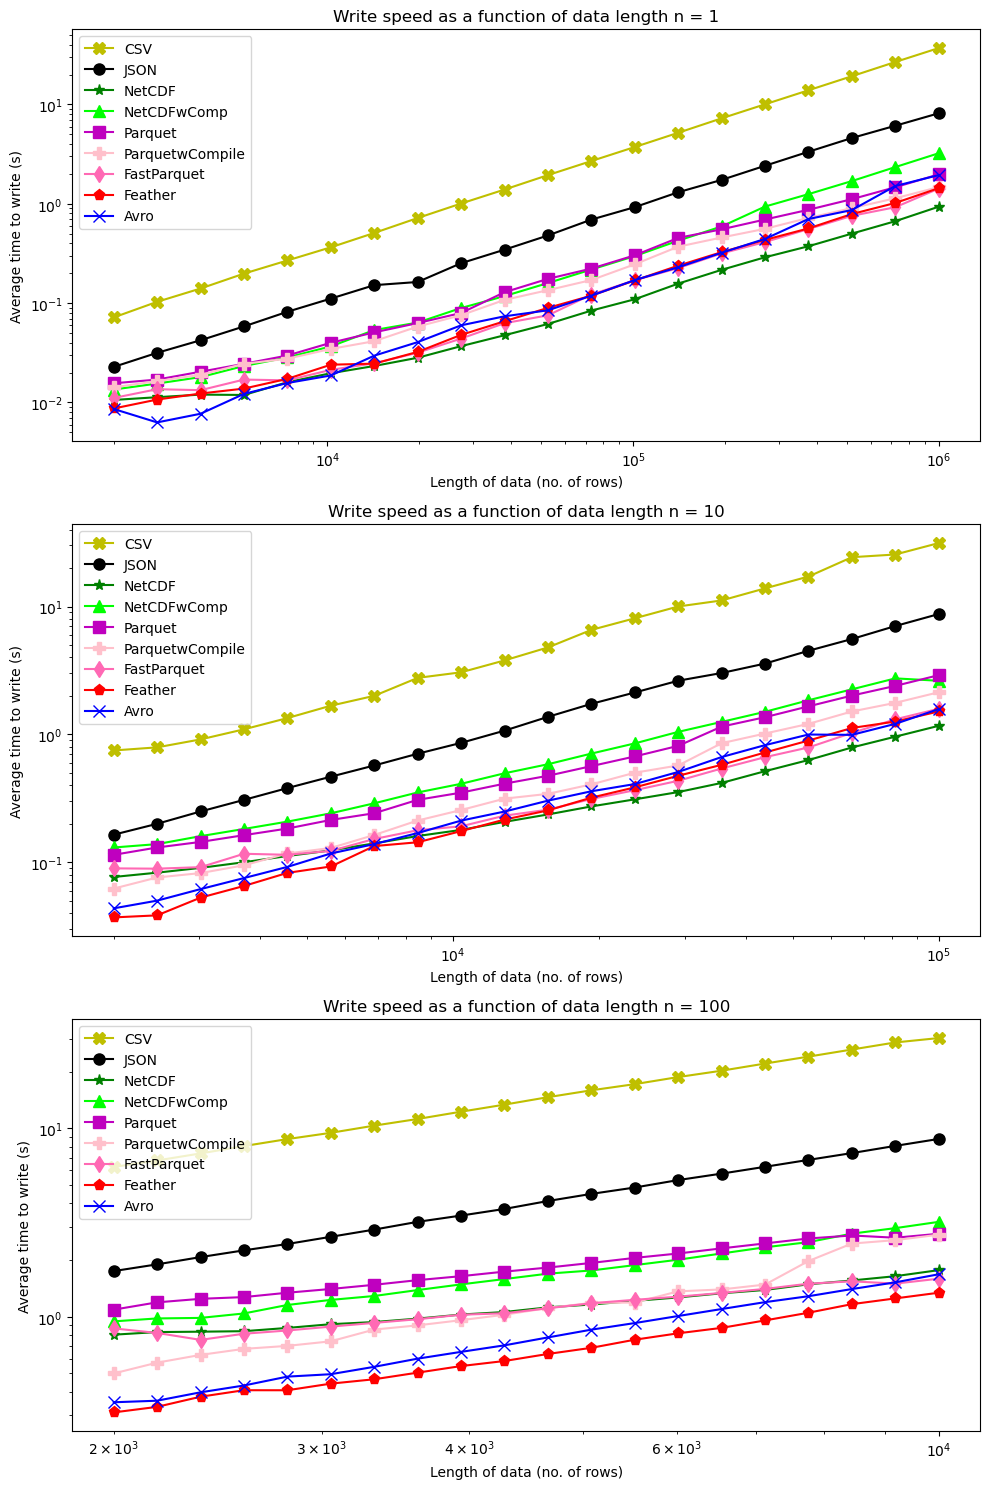

In [116]:
# Writing speed results
plt.subplots(figsize=(10, 15))

for n_index, n in enumerate(ns_to_write):
    plot_num = n_index + 1
    plt.subplot(3, 1, plot_num)
    plt.title(f'Write speed as a function of data length n = {n}')
    plt.xlabel('Length of data (no. of rows)')
    plt.ylabel('Average time to write (s)')
    for i, formats in enumerate(results.keys()):
        if(results[formats]):
            plt.loglog(data_lengths_across_n[n_index], results[formats][DataMetricsPos['Writing'].value][n_index], 
                     color = format_colors[i], marker = markers[i], markersize =8, label = formats )
    plt.legend()
plt.tight_layout() # To make the plots fit nicely
plt.show()

# For 1e6 records, JSON - 8.15s, NetCDF - 0.93s, NetwComp - 3.2s  Parquet - 1.97s, 

C:\Users\megan\AppData\Local\Temp\ipykernel_11160\3192247986.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 1, plot_num)


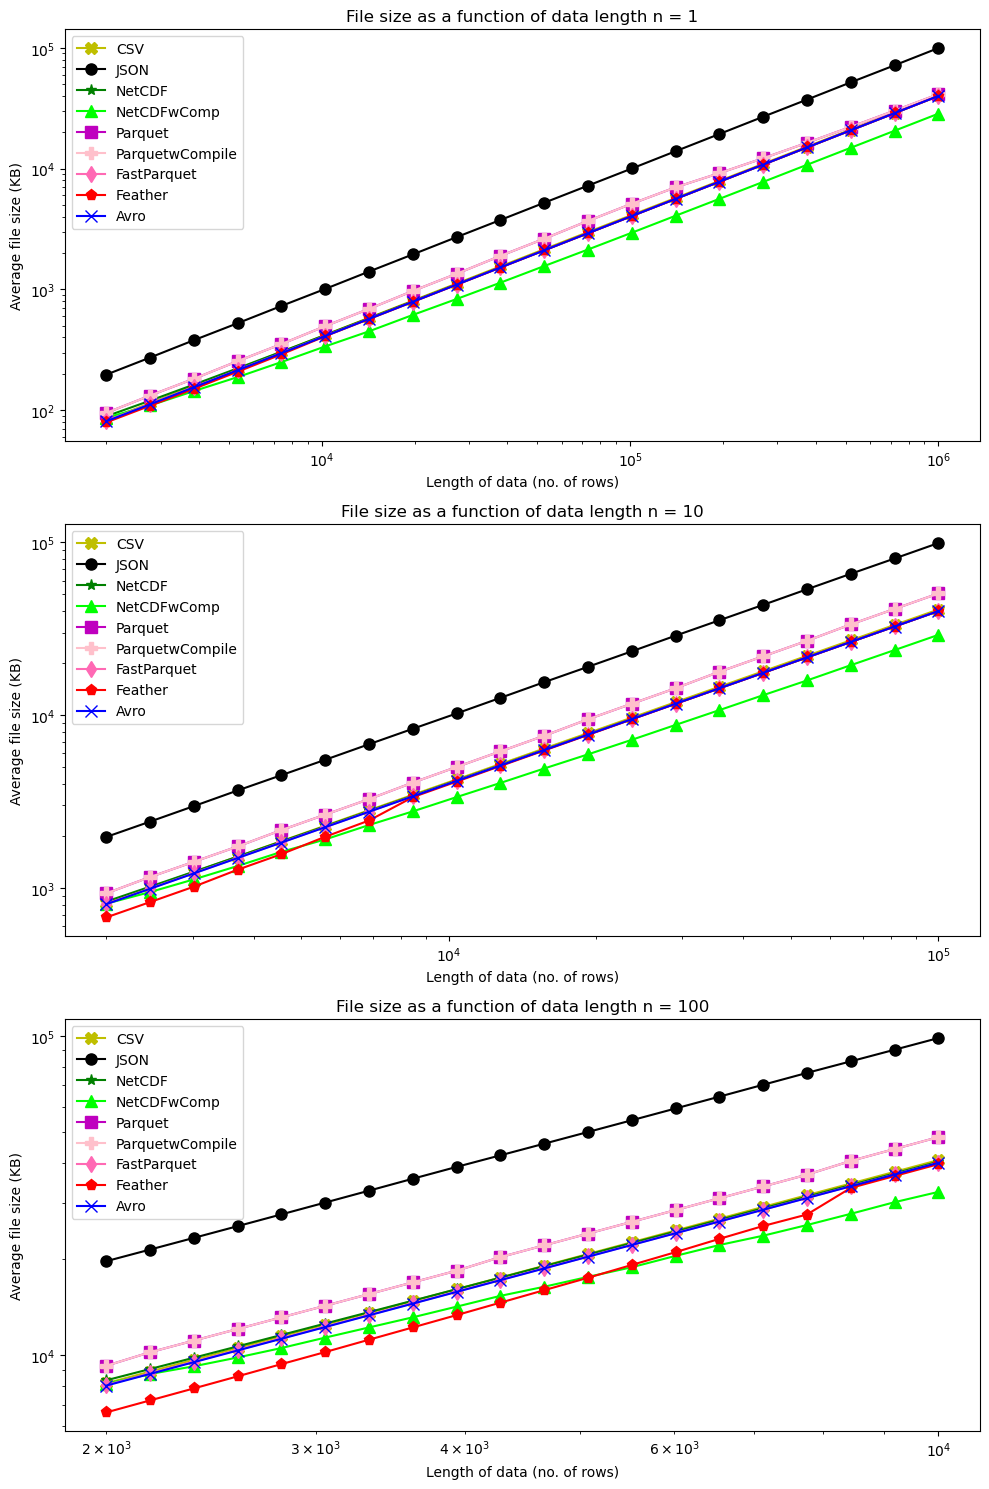

In [117]:
# Data size speed results
plt.subplots(figsize=(10, 15))

for n_index, n in enumerate(ns_to_write):
    plot_num = n_index + 1
    plt.subplot(3, 1, plot_num)
    plt.title(f'File size as a function of data length n = {n}')
    plt.xlabel('Length of data (no. of rows)')
    plt.ylabel('Average file size (KB)')
    plt.ticklabel_format(style='plain')
    for i, formats in enumerate(results.keys()):
         if(results[formats]):
            plt.loglog(data_lengths_across_n[n_index], results[formats][DataMetricsPos['Filesize'].value][n_index], 
                     color = format_colors[i], marker = markers[i], markersize =8, label = formats )
    plt.legend()
plt.tight_layout() # To make the plots fit nicely
plt.show()

# For 1e6 records, JSON - 99758.3575 KB, NetCDF - 40009.0002 KB, NetwComp - 28552.1904KB  Parquet -  41395.2123 KB, 

C:\Users\megan\AppData\Local\Temp\ipykernel_11160\1561319862.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 1, plot_num)


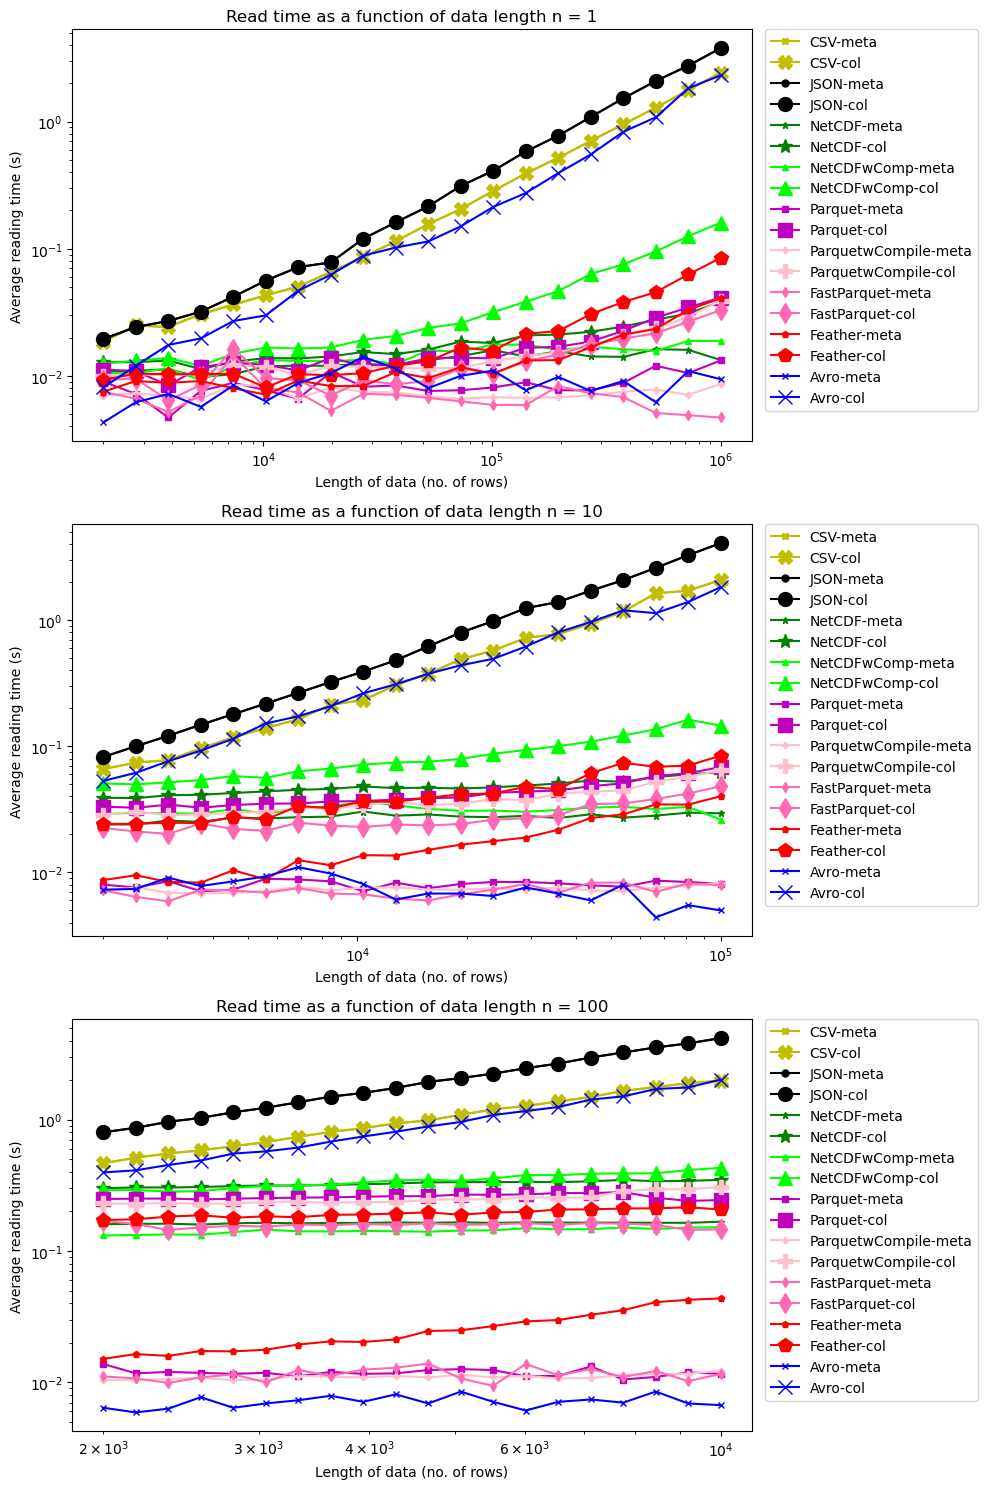

In [118]:
# Reading speed results
plt.subplots(figsize=(10, 15))
for n_index, n in enumerate(ns_to_write):
    plot_num = n_index + 1
    plt.subplot(3, 1, plot_num)
    plt.title(f'Read time as a function of data length n = {n}')
    plt.xlabel('Length of data (no. of rows)')
    plt.ylabel('Average reading time (s)')
    plt.ticklabel_format(style='plain')
    for i, formats in enumerate(results.keys()):
         if(results[formats]):
            plt.loglog(data_lengths_across_n[n_index], results[formats][DataMetricsPos['Metaread'].value][n_index], 
                     color = format_colors[i], marker = markers[i], markersize =5, label = str(formats + "-meta"))
            plt.loglog(data_lengths_across_n[n_index], results[formats][DataMetricsPos['Colread'].value][n_index], 
                     color = format_colors[i], marker = markers[i], markersize =10, label = str(formats + "-col") )
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    
plt.tight_layout() # To make the plots fit nicely
plt.show()

In [27]:
# Scratch space
'''
def FPQ_write_n_to_file(length_of_data, n_to_write, fp = None):
    
    if fp is None:
        fp = 'FPQTestFile.parq'
        
    if os.path.exists(fp):
        os.unlink(fp)
    
    then = time_ns()

    custom_metadata = FPQ_make_custom_meta(n_to_write)

    
    for i in range(n_to_write):
        df = pd.DataFrame(make_test_data(length_of_data))
        table = pa.Table.from_pandas(df, preserve_index=False)
        append = False if i == 0 else True
        if i == 0:
            fpq.write(fp, df, row_group_offsets = length_of_data, append =append, custom_metadata = custom_metadata)
        else:
            file = fpq.ParquetFile(fp)
            file.write_row_groups(df, row_group_offsets = length_of_data)
#         fpq.write(fp, df, row_group_offsets = length_of_data, append =append, custom_metadata = custom_metadata)

    now = time_ns()
    file_size = os.path.getsize(fp)/1000 #to get in kb
    return (now-then) * 1e-9, file_size
'''

x=5